# Train Stats

```
 ----------------------------------------------------------------------------------------
/                                                                                        \
| /$$$$$$$$                 /$$            /$$$$$$   /$$                 /$$             |
||__  $$__/                |__/           /$$__  $$ | $$                | $$             |
|   | $$  /$$$$$$  /$$$$$$  /$$ /$$$$$$$ | $$  \__//$$$$$$    /$$$$$$  /$$$$$$   /$$$$$$$|
|   | $$ /$$__  $$|____  $$| $$| $$__  $$|  $$$$$$|_  $$_/   |____  $$|_  $$_/  /$$_____/|
|   | $$| $$  \__/ /$$$$$$$| $$| $$  \ $$ \____  $$ | $$      /$$$$$$$  | $$   |  $$$$$$ |
|   | $$| $$      /$$__  $$| $$| $$  | $$ /$$  \ $$ | $$ /$$ /$$__  $$  | $$ /$$\____  $$|
|   | $$| $$     |  $$$$$$$| $$| $$  | $$|  $$$$$$/ |  $$$$/|  $$$$$$$  |  $$$$//$$$$$$$/|
|   |__/|__/      \_______/|__/|__/  |__/ \______/   \___/   \_______/   \___/ |_______/ |
|                                                                                        |
|                                                                                        |
|                                                                                        |
|                                      🚂 ¯\_(ツ)_/¯?                                     |
\                                                                                        /
 ----------------------------------------------------------------------------------------
    \     
     \     
      \      
           ___ ____
         ⎛   ⎛ ,----
          \  //==--'
     _//|,.·//==--'    ____________________________
    _OO≣=-  ︶ ᴹw ⎞_§ ______  ___\ ___\ ,\__ \/ __ \
   (∞)_, )  (     |  ______/__  \/ /__ / /_/ / /_/ /
     ¨--¨|| |- (  / ______\____/ \___/ \__^_/  .__/
         ««_/  «_/ jgs/bd808                /_/
```

In which I look at data from the past several hundred trains and pretend that I know how to do exploratory data analysis.

In [23]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

engine = create_engine('sqlite:///data/train.db')
df = pd.read_sql('''
SELECT
    version,
    rollbacks,
    rollbacks_time,
    patches,
    group2_delay_days,
    (group0_delay_days +
     group1_delay_days +
     group2_delay_days) as total_delay,
    total_time as train_total_time,
    (select sum(time_in_review) from patch p where p.train_id = t.id) as time_in_review,
    (select sum(comments) from patch where patch.train_id = t.id) as comments,
    (select count(*) from blocker b where b.train_id = t.id and resolved = 1) as blockers
FROM train t
''', engine)

# Makes your data 538% better...I think
plt.style.use('fivethirtyeight')
df.head()

,version,rollbacks,rollbacks_time,patches,group2_delay_days,total_delay,train_total_time,time_in_review,comments,blockers
0,1.37.0-wmf.1,0,0,450,0,0,178349,376214457,1175,3
1,1.37.0-wmf.3,3,94493,366,0,1,219880,381894655,1263,6
2,1.37.0-wmf.4,1,66812,422,1,3,263742,328555632,1341,4
3,1.36.0-wmf.1,0,0,566,4,4,519622,305598768,1113,1
4,1.36.0-wmf.2,4,389769,273,4,5,554704,283073424,899,1


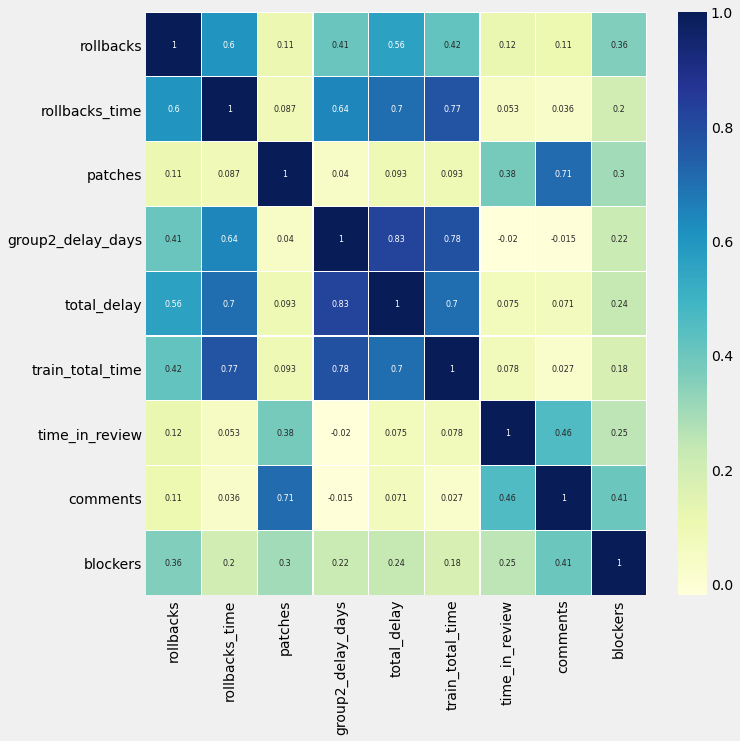

In [24]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu", linewidths=0.3, annot_kws={"size": 8}, ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Text(0.5, 1.02, 'Blockers per Train')

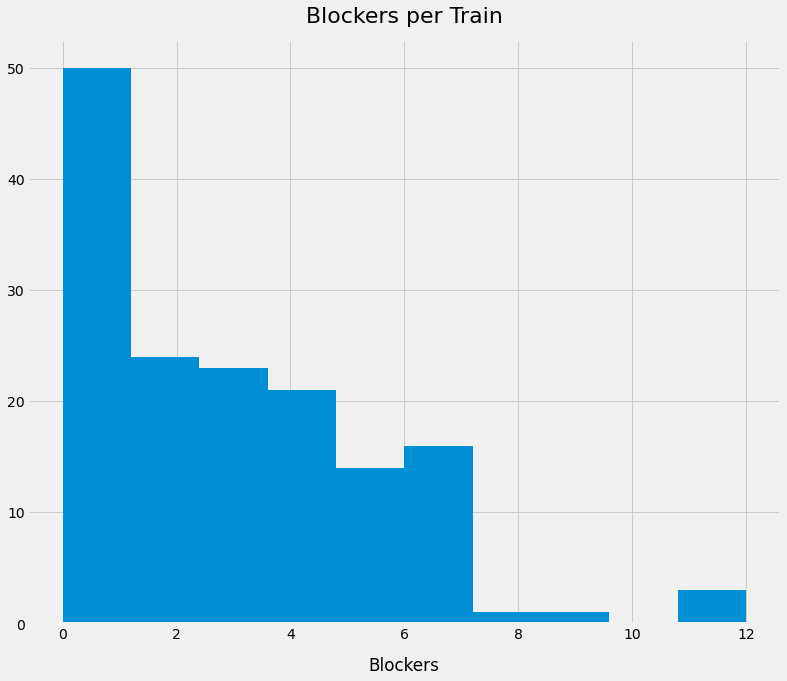

In [102]:
df.set_index('version')['blockers'].hist(figsize=(12, 10))
plt.xlabel("Blockers", labelpad=15)
plt.title("Blockers per Train", y=1.02, fontsize=22)

In [36]:
df[df['blockers'] > 5].sort_values(by='blockers', ascending=False)

,version,rollbacks,rollbacks_time,patches,group2_delay_days,total_delay,train_total_time,time_in_review,comments,blockers
136,1.31.0-wmf.20,2,134534,822,1,5,255075,944016896,4330,12
103,1.33.0-wmf.22,0,0,391,0,1,63844,617659650,1608,11
82,1.34.0-wmf.20,1,16897,413,5,5,600096,319451631,1008,11
135,1.31.0-wmf.16,1,431612,288,5,12,562921,184008614,1708,9
76,1.34.0-wmf.13,2,14912,471,0,1,183853,524649491,1545,8
88,1.33.0-wmf.1,3,103185,237,0,1,174970,259176121,888,7
127,1.32.0-wmf.26,3,95057,673,0,2,174156,685559052,2194,7
124,1.32.0-wmf.22,0,0,824,0,0,173055,538417283,2283,7
111,1.32.0-wmf.5,0,0,236,5,5,607929,390841864,912,7
105,1.33.0-wmf.24,4,385068,314,4,9,520660,193963293,1224,7


In [37]:
block_df = pd.read_sql('''
SELECT
    version,
    group_blocked
FROM train t
JOIN blocker b ON t.id = b.train_id
''', engine)
block_df.head()

,version,group_blocked
0,1.37.0-wmf.7,-1
1,1.37.0-wmf.7,-1
2,1.37.0-wmf.12,2
3,1.37.0-wmf.12,1
4,1.37.0-wmf.12,1


In [42]:
block_df.group_blocked.unique()

array([-1,  2,  1,  0])

In [51]:
group_name_map = {
    -1: "Earlier",
    0: "Group0",
    1: "Group1",
    2: "Group2",
}
block_df['blocker_added'] = block_df.group_blocked.map(group_name_map)
block_df.head()

,version,group_blocked,blocker_added
0,1.37.0-wmf.7,-1,Earlier
176,1.36.0-wmf.35,-1,Earlier
177,1.36.0-wmf.35,-1,Earlier
178,1.36.0-wmf.35,-1,Earlier
179,1.36.0-wmf.35,-1,Earlier


In [83]:
block_df.group_blocked.value_counts()

-1    233
 1    230
 0    180
 2     91
Name: group_blocked, dtype: int64

In [100]:
block_df.version

0       1.37.0-wmf.7
6       1.37.0-wmf.1
672     1.31.0-wmf.2
671     1.31.0-wmf.2
666    1.32.0-wmf.26
           ...      
334    1.35.0-wmf.41
194    1.36.0-wmf.37
530    1.33.0-wmf.20
185    1.36.0-wmf.36
425    1.34.0-wmf.16
Name: version, Length: 734, dtype: object

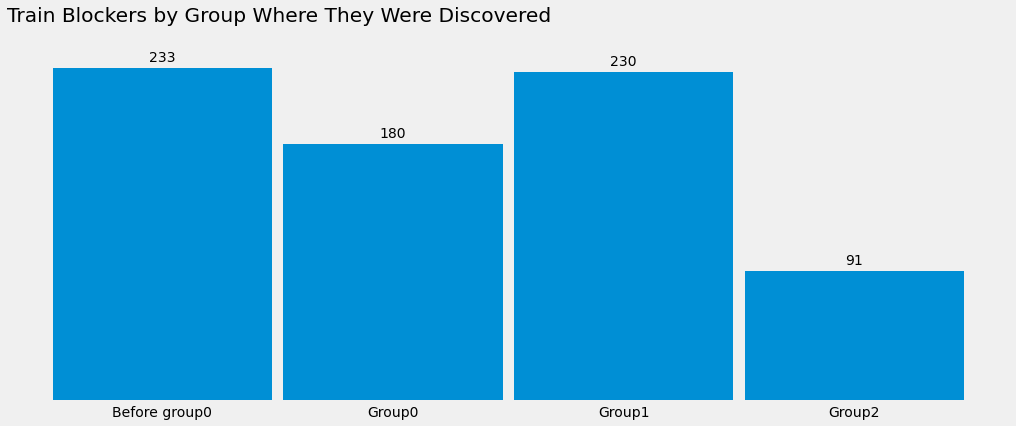

In [98]:
block_df.set_index('version')
block_df.sort_values('group_blocked', inplace=True)


fig = plt.figure(figsize=(16,6))
plt.grid(color='white', lw=0.5, axis='x')
n, bins, patches = plt.hist(block_df.blocker_added, bins=4, rwidth=0.95)

xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
xticks_labels = [ "{:.2f}\nto\n{:.2f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels=["Before group0", "Group0", "Group1", "Group2"])

# remove y ticks
plt.yticks([])

# plot values on top of bars
for idx, value in enumerate(n):
    if value > 0:
        plt.text(xticks[idx], value+5, int(value), ha='center')

plt.title('Train Blockers by Group Where They Were Discovered', loc='left', pad=30)
plt.show()
